In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
class SpectrogramDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.encoder = LabelEncoder()
        self.img_labels['class'] = self.encoder.fit_transform(self.img_labels['class'])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = str(self.img_labels.iloc[idx]['idx'])
        if not img_name.endswith('.png'):  
            img_name += '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [33]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

img_dir = './data-images/train'

train_data = SpectrogramDataset(annotations_file='./train_labels.csv', img_dir=img_dir, transform=transform)
test_data = SpectrogramDataset(annotations_file='./test_labels.csv', img_dir=img_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [34]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

for name, child in model.named_children():
    if name in ['layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/sanders/2024_1/ml-project-4/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanders/2024_1/ml-project-4/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [36]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloaders['train'].dataset)}")


In [37]:
dataloaders = {'train': train_loader, 'test': test_loader}
train_model(model, dataloaders, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.27648192794885557
Epoch 2/2, Loss: 0.17508022506073215


In [38]:
def get_predicted_labels(model, dataloader):
    model.eval() 
    predicted_labels = []
    with torch.no_grad():  #
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())  # Almacenar
    
    return predicted_labels

In [39]:
predicted_labels = get_predicted_labels(model, test_loader)
print(predicted_labels)

[1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 

In [40]:
real_labels = pd.read_csv('./test_labels.csv')
real_labels['class'] = train_data.encoder.transform(real_labels['class'])

accuracy = (real_labels['class'] == predicted_labels).mean() * 100

print(f"El accuracy es: {accuracy:.2f}%")

El accuracy es: 91.77%


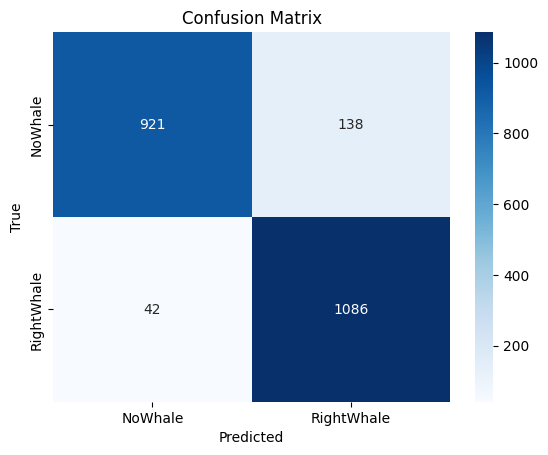

In [43]:
cm = confusion_matrix(real_labels['class'], predicted_labels)

# Visualización de la matriz de confusión con nombres de clases
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=train_data.encoder.classes_,
            yticklabels=train_data.encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
precision = precision_score(real_labels['class'], predicted_labels)
recall = recall_score(real_labels['class'], predicted_labels)
f1 = f1_score(real_labels['class'], predicted_labels)
roc_auc = roc_auc_score(real_labels['class'], predicted_labels)  

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Value': [precision, recall, f1, roc_auc]
})

print(results)

      Metric     Value
0  Precision  0.887255
1     Recall  0.962766
2   F1 Score  0.923469
3    ROC-AUC  0.916227
